In [1]:
!mkdir data
%cd data

!gdown 1SFWQ7Zi83Gff-RVrlHj0z4Llm1Nq4BBA

%cd ..

d:\AIVietNam\2024\aio-2024-hw\module-5\26_10_2024_M05W01\data


A subdirectory or file data already exists.


d:\AIVietNam\2024\aio-2024-hw\module-5\26_10_2024_M05W01


Downloading...
From: https://drive.google.com/uc?id=1SFWQ7Zi83Gff-RVrlHj0z4Llm1Nq4BBA
To: d:\AIVietNam\2024\aio-2024-hw\module-5\26_10_2024_M05W01\data\titanic_modified_dataset.csv

  0%|          | 0.00/25.9k [00:00<?, ?B/s]
100%|██████████| 25.9k/25.9k [00:00<?, ?B/s]


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
dataset_path = './data/titanic_modified_dataset.csv'
df = pd.read_csv(dataset_path, index_col='PassengerId')
df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Survived
PassengerId,,,,,,,,,
1,3,0,22.0,1,0,7.2500,0,0,0
2,1,1,38.0,1,0,71.2833,1,1,1
3,3,1,26.0,0,0,7.9250,0,2,1
4,1,1,35.0,1,0,53.1000,0,1,1
5,3,0,35.0,0,0,8.0500,0,0,0


In [4]:
ds_arr = df.to_numpy().astype(np.float64)
X, y = ds_arr[:, :-1], ds_arr[:, -1]

In [5]:
# If using library, bias will auto added into X. But since we impl from scratch, we need to do it manually
intercept = np.ones((X.shape[0], 1))
X_b = np.hstack((intercept, X))
X_b

array([[ 1.    ,  3.    ,  0.    , ...,  7.25  ,  0.    ,  0.    ],
       [ 1.    ,  1.    ,  1.    , ..., 71.2833,  1.    ,  1.    ],
       [ 1.    ,  3.    ,  1.    , ...,  7.925 ,  0.    ,  2.    ],
       ...,
       [ 1.    ,  3.    ,  1.    , ..., 23.45  ,  0.    ,  2.    ],
       [ 1.    ,  1.    ,  0.    , ..., 30.    ,  1.    ,  0.    ],
       [ 1.    ,  3.    ,  0.    , ...,  7.75  ,  2.    ,  0.    ]],
      shape=(891, 9))

In [6]:
val_size=0.2
test_size=0.125
random_state=2
is_shuffle=True

X_train, X_val, y_train, y_val = train_test_split(
    X_b, y,
    test_size=val_size,
    random_state=random_state,
    shuffle=is_shuffle
)
X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=test_size,
    random_state=random_state,
    shuffle=is_shuffle
)

In [7]:
normalizer = StandardScaler()
X_train[:, 1:] = normalizer.fit_transform(X_train[:, 1:]) # skip bias
X_val[:, 1:] = normalizer.transform(X_val[:, 1:])
X_test[:, 1:] = normalizer.transform(X_test[:, 1:])

In [8]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def predict(X, theta):
    dot_product = np.dot(X, theta)
    y_hat = sigmoid(dot_product)
    return y_hat

$loss(y,\hat{y})=-\frac{1}{\text{batch size}}\sum^{\text{batch size}}_{i=1}(y_i\times\log(\hat{y}_i)+(1-\hat{y}_i\times\log(1-\hat{y}_i))$

In [9]:
# Clip (limit) the values in an array.
# Given an interval, values outside the interval are clipped to the interval edges.
# For example, if an interval of [0, 1] is specified, values smaller than 0 become 0, and values larger than 1 become 1.
# Equivalent to but faster than np.minimum(a_max, np.maximum(a, a_min)).
def compute_loss(y_hat, y):
    y_hat = np.clip(y_hat, 1e-7, 1 - 1e-7)
    return (
        -y *
        np.log(y_hat) - (1 - y) *
        np.log(1 - y_hat)
    ).mean()

$gradient(X,y,\hat{y})=\frac{X^T\cdot(\hat{y}-y)}{\text{batch size}}$

In [10]:
def compute_gradient(X, y, y_hat):
    return np.dot(X.T, (y_hat - y)) / y.size

$\theta=\theta-lr \times gradient$

In [11]:
def update_theta(theta, gradient, lr):
    return theta - lr * gradient

$accuracy=\frac{\text{Số lần dự đoán đúng}}{\text{Tổng số lần dự đoán}}$

In [12]:
def compute_accuracy(X, y, theta):
    y_hat = predict(X, theta).round()
    acc = (y_hat == y).mean()
    
    return acc

In [13]:
lr = 0.01
epochs = 100
batch_size = 16

np.random.seed(random_state)
theta = np.random.uniform(
    size=X_train.shape[1]
)

In [14]:
train_accs = []
train_losses = []
val_accs = []
val_losses = []

for epoch in range(epochs):
    train_batch_losses = []
    train_batch_accs = []
    val_batch_losses = []
    val_batch_accs = []
    
    for i in range(0, X_train.shape[0], batch_size):
        X_i = X_train[i:i+batch_size]
        y_i = y_train[i:i+batch_size]
        
        y_hat = predict(X_i, theta)
        
        train_loss = compute_loss(y_hat, y_i)
        gradient = compute_gradient(X_i, y_i, y_hat)
        theta = update_theta(theta, gradient, lr)
        
        train_batch_losses.append(train_loss)
        
        train_acc = compute_accuracy(X_train, y_train, theta)
        train_batch_accs.append(train_acc)
        
        y_val_hat = predict(X_val, theta)
        val_loss = compute_loss(y_val_hat, y_val)
        val_batch_losses.append(val_loss)
        
        val_acc = compute_accuracy(X_val, y_val, theta)
        val_batch_accs.append(val_acc)
        
    train_batch_loss = sum(train_batch_losses) / len(train_batch_losses)
    val_batch_loss = sum(val_batch_losses) / len(val_batch_losses)
    train_batch_acc = sum(train_batch_accs) / len(train_batch_accs)
    val_batch_acc = sum(val_batch_accs) / len(val_batch_accs)
    
    train_losses.append(train_batch_loss)
    val_losses.append(val_batch_loss) 
    train_accs.append(train_batch_acc)
    val_accs.append(val_batch_acc)
    
    print (f'\nEPOCH {epoch + 1}:\tTraining loss : {train_batch_loss:.3f}\tValidation loss : {val_batch_loss :.3f}')


EPOCH 1:	Training loss : 0.703	Validation loss : 0.599

EPOCH 2:	Training loss : 0.670	Validation loss : 0.582

EPOCH 3:	Training loss : 0.640	Validation loss : 0.567

EPOCH 4:	Training loss : 0.614	Validation loss : 0.555

EPOCH 5:	Training loss : 0.592	Validation loss : 0.544

EPOCH 6:	Training loss : 0.572	Validation loss : 0.535

EPOCH 7:	Training loss : 0.554	Validation loss : 0.528

EPOCH 8:	Training loss : 0.539	Validation loss : 0.522

EPOCH 9:	Training loss : 0.526	Validation loss : 0.517

EPOCH 10:	Training loss : 0.514	Validation loss : 0.513

EPOCH 11:	Training loss : 0.504	Validation loss : 0.509

EPOCH 12:	Training loss : 0.495	Validation loss : 0.507

EPOCH 13:	Training loss : 0.487	Validation loss : 0.505

EPOCH 14:	Training loss : 0.480	Validation loss : 0.503

EPOCH 15:	Training loss : 0.474	Validation loss : 0.502

EPOCH 16:	Training loss : 0.468	Validation loss : 0.501

EPOCH 17:	Training loss : 0.463	Validation loss : 0.500

EPOCH 18:	Training loss : 0.459	Validat

Text(0.5, 1.0, 'Validation Accuracy')

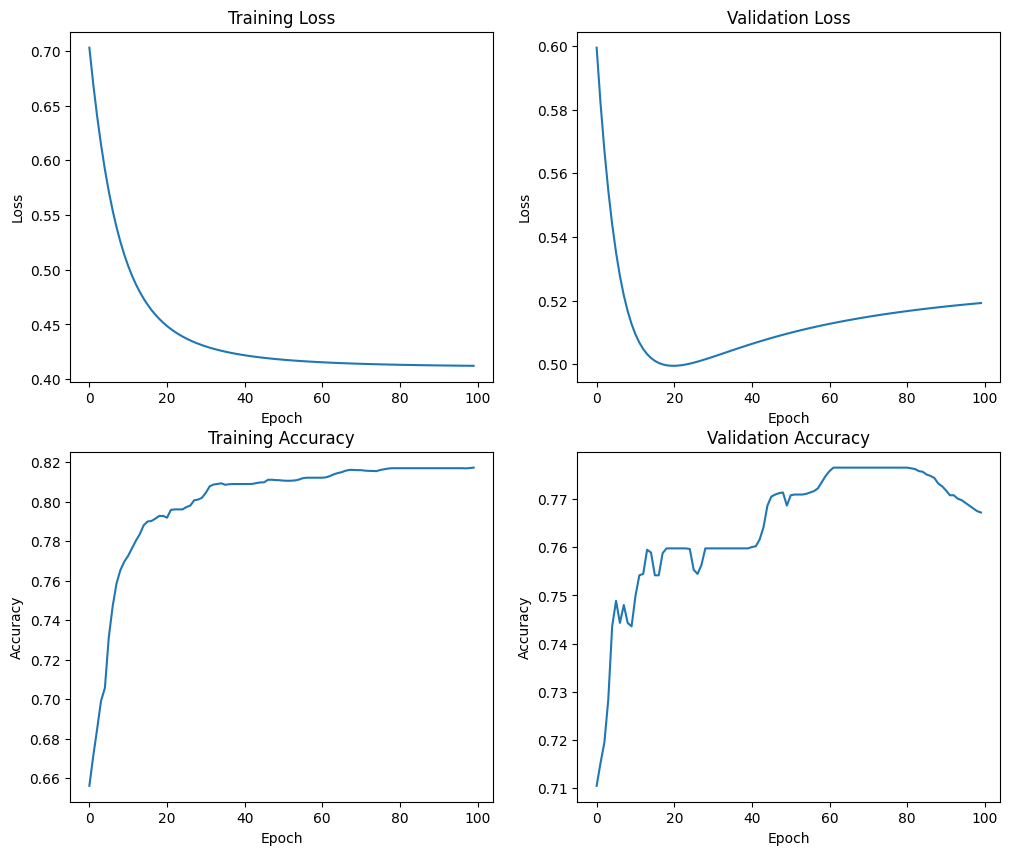

In [15]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses)
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_losses)
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_accs)
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_accs)
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

In [16]:
val_set_acc = compute_accuracy(X_val, y_val, theta)
test_set_acc = compute_accuracy(X_test, y_test, theta)
print('Evaluation on validation and test set')
print(f'Accuracy: {val_set_acc}')
print(f'Accuracy: {test_set_acc}')

Evaluation on validation and test set
Accuracy: 0.770949720670391
Accuracy: 0.7752808988764045
